## compute the FIDs for the generated samples in the MNIST experiment

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from typing import Tuple
import numpy as np
import tensorflow as tf
from scipy import linalg as ln
import gc


def prepare_32x32_grayscale(imgs):
    """
    Make to range [0,255] with 3 channels, from 32x32 grayscale inputs.
    Accepts shapes:
      [N, 32, 32], [N,32,32,1], [N,32,32,3] (if already RGB)
    Returns:
      imgs_rgb: np.float32 array shape [N, 32, 32, 3] with values in [0,255]
    """
    imgs = imgs.astype(np.float32)
    if imgs.ndim == 3:
        imgs = imgs[..., None]  # [N,H,W,1]

    if imgs.shape[-1] == 1:
        imgs = np.repeat(imgs, 3, axis=-1)  # [N,H,W,3]
    elif imgs.shape[-1] == 3:
        pass
    else:
        raise ValueError(f"Unsupported channel dimension: {imgs.shape}")

    imgs = imgs * 255.0

    return imgs.astype(np.float32)


def build_inception_model():
    """Return Keras InceptionV3 model producing 2048-d pooled features."""
    model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", pooling="avg")
    return model



def get_activations(model: tf.keras.Model, imgs_32: np.ndarray, batch_size: int = 50) -> np.ndarray:
    """
    Run imgs_32 (N,32,32,3) through the model.
    Resizes to 299x299 per-batch, applies preprocess_input, returns activations (N,2048).
    """
    n = imgs_32.shape[0]
    acts = []
    for start in range(0, n, batch_size):
        end = min(n, start + batch_size)
        batch = imgs_32[start:end]  # numpy array float32 0..255

        batch_tf = tf.convert_to_tensor(batch)  # dtype float32
        # Resize to Inception expected 299x299
        batch_tf = tf.image.resize(batch_tf, (299, 299))

        # Preprocess: maps [0,255] -> [-1,1]
        batch_tf = tf.keras.applications.inception_v3.preprocess_input(batch_tf)
        preds = model(batch_tf, training=False)
        acts.append(preds.numpy())
    acts = np.concatenate(acts, axis=0)
    return acts  # shape (N,2048)


def compute_statistics(features: np.ndarray):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = ln.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = ln.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        # if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
        #     m = np.max(np.abs(covmean.imag))
        #     raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def compute_fid_from_32x32(imgs1, imgs2, batch_size, verbose=False):

    processed_imgs1 = prepare_32x32_grayscale(imgs1)
    processed_imgs2 = prepare_32x32_grayscale(imgs2)

    if verbose:
        print(f"Set A: {imgs1.shape}, Set B: {imgs2.shape}")
        print("Building InceptionV3 model (may download weights)...")

    model = build_inception_model()

    if verbose:
        print("Computing activations for set A...")
    features1 = get_activations(model, processed_imgs1, batch_size=batch_size)
    if verbose:
        print("Computing activations for set B...")
    features2 = get_activations(model, processed_imgs2, batch_size=batch_size)

    if verbose:
        print("Activations shapes:", features1.shape, features2.shape)

    mu1, sigma1 = compute_statistics(features1)
    mu2, sigma2 = compute_statistics(features2)

    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

2026-01-03 15:37:03.989384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767454624.009848 2643839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767454624.015718 2643839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-03 15:37:04.038895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## load results for the digit

In [2]:
digit = 4
all_gaussian_samples = np.load(f'samples/digit_{digit}/gaussian_samples_mnist_digit_{digit}.npy')
all_gaussian_dists_to_data = np.load(f'samples/digit_{digit}/gaussian_dists_to_data_digit_{digit}.npy')
all_gaussian_dists_to_manifold = np.load(f'samples/digit_{digit}/gaussian_dists_to_manifold_digit_{digit}.npy')

all_adapted_samples = np.load(f'samples/digit_{digit}/adapted_samples_mnist_digit_{digit}.npy')
all_adapted_dists_to_data = np.load(f'samples/digit_{digit}/adapted_dists_to_data_digit_{digit}.npy')
all_adapted_dists_to_manifold = np.load(f'samples/digit_{digit}/adapted_dists_to_manifold_digit_{digit}.npy')

all_KDE_samples = np.load(f'samples/digit_{digit}/KDE_samples_mnist_digit_{digit}.npy')
all_KDE_dists_to_data = np.load(f'samples/digit_{digit}/KDE_dists_to_data_digit_{digit}.npy')
all_KDE_dists_to_manifold = np.load(f'samples/digit_{digit}/KDE_dists_to_manifold_digit_{digit}.npy')

fid_images = np.load(f'samples/digit_{digit}/fid_images.npy')

## compute FIDs

In [3]:
all_gaussian_fids = []
for i in range(all_gaussian_samples.shape[0]):
    samples = all_gaussian_samples[i]
    fid = compute_fid_from_32x32(samples, fid_images, batch_size=10, verbose=False)
    all_gaussian_fids.append(fid)
    print(f"Gaussian sample {i} FID: {fid}")

    tf.keras.backend.clear_session()   # releases TF graphs/vars
    gc.collect()

I0000 00:00:1767454627.664040 2643839 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1767454630.779909 2643839 cuda_dnn.cc:529] Loaded cuDNN version 90501


Gaussian sample 0 FID: 16.031745671057863
Gaussian sample 1 FID: 31.233936994482903
Gaussian sample 2 FID: 70.34993982352361
Gaussian sample 3 FID: 92.48302733080799
Gaussian sample 4 FID: 98.68938268957908
Gaussian sample 5 FID: 100.97676847464638
Gaussian sample 6 FID: 101.01836778750103
Gaussian sample 7 FID: 99.62564046447572


In [4]:
all_adapted_fids = []
for i in range(all_adapted_samples.shape[0]):
    samples = all_adapted_samples[i]
    fid = compute_fid_from_32x32(samples, fid_images, batch_size=10, verbose=False)
    all_adapted_fids.append(fid)
    print(f"Adapted sample {i} FID: {fid}")

    tf.keras.backend.clear_session()   # releases TF graphs/vars
    gc.collect()

Adapted sample 0 FID: 16.031745022929186
Adapted sample 1 FID: 17.15334700276219
Adapted sample 2 FID: 17.399084918850676
Adapted sample 3 FID: 16.965397660119493
Adapted sample 4 FID: 18.643834622251376
Adapted sample 5 FID: 19.41571431633787
Adapted sample 6 FID: 22.048387937352246
Adapted sample 7 FID: 25.74369016777301


## make plots

In [5]:
import matplotlib.pyplot as plt
from src.plotting import add_arrows

# plot formatting
import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

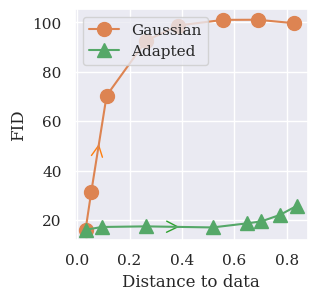

In [6]:
avg_gaussian_data_distances = np.mean(all_gaussian_dists_to_data, axis=1)
avg_gaussian_manifold_distances = np.mean(all_gaussian_dists_to_manifold, axis=1)

avg_adapted_data_distances = np.mean(all_adapted_dists_to_data, axis=1)
avg_adapted_manifold_distances = np.mean(all_adapted_dists_to_manifold, axis=1)

# Plot scatter plot with arrows
plt.figure(figsize=(3,3))

# Plot and extract line objects

pal = sns.color_palette()   # nice, colorblind-safe seaborn palette
orange, green = pal[1], pal[2]  

line_gaussian = plt.plot(avg_gaussian_data_distances, all_gaussian_fids,  marker='o', ms=10, label='Gaussian', color=orange)[0]
line_adapted = plt.plot(avg_adapted_data_distances, all_adapted_fids,  marker='^', ms=10, label='Adapted', color=green)[0]

# Add arrows to the lines
add_arrows(line_gaussian, segment_index=1, color='tab:orange')
add_arrows(line_adapted, segment_index=2, color='tab:green')

plt.xlabel("Distance to data")
plt.ylabel("FID")
plt.grid(True)

# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')
plt.legend(loc='upper left')

fig_dir = f'figures/mnist/digit_{digit}'
os.makedirs(fig_dir, exist_ok=True)

plt.savefig(f"{fig_dir}/mnist_fid_{digit}s.pdf", bbox_inches='tight')

plt.show()